In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# import data from previous wrangle and EDA notebooks
df_houses = pd.read_csv('houses.csv')
final_test_df = pd.read_csv('houses_test.csv')

In [3]:
df_houses

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,Typ,0,0,Attchd,2003.0,2,2,548,3,3,Y,0,61,0,0,0,0,0,0,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,Typ,1,3,Attchd,1976.0,2,2,460,3,3,Y,298,0,0,0,0,0,0,0,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,Typ,1,3,Attchd,2001.0,2,2,608,3,3,Y,0,42,0,0,0,0,0,0,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,Typ,1,4,Detchd,1998.0,1,3,642,3,3,Y,0,35,272,0,0,0,0,0,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,Typ,1,3,Attchd,2000.0,2,3,836,3,3,Y,192,84,0,0,0,0,0,0,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,3,PConc,4,3,1,1,0,1,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,3,7,Typ,1,3,Attchd,1999.0,2,2,460,3,3,Y,0,40,0,0,0,0,0,0,NaN,0,8,2007,WD,Normal,175000
1455,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,3,3,CBlock,4,3,1,5,790,3,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,3,7,Min1,2,3,Attchd,1978.0,1,2,500,3,3,Y,349,0,0,0,0,0,0,4,NaN,0,2,2010,WD,Normal,210000
1456,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,5,4,Stone,3,4,1,6,275,1,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,4,9,Typ,2,4,Attchd,1941.0,2,1,252,3,3,Y,0,60,0,0,0,0,0,5,Shed,2500,5,2010,WD,Normal,266500
1457,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,3,3,2,6,49,3,1029,0,1078,GasA,...,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,4,5,Typ,0,0,Attchd,1950.0,1,1,240,3,3,Y,366,0,112,0,0,0,0,0,NaN,0,4,2010,WD,Normal,142125


In [4]:
df_houses.drop(columns =['Id'], inplace=True)
Id = final_test_df['Id']
final_test_df.drop(columns =['Id'], inplace=True)

In [5]:
# Engeneer a few features

df_houses['Age']= df_houses['YrSold'] - df_houses['YearBuilt']
final_test_df['Age']= final_test_df['YrSold'] - final_test_df['YearBuilt']

df_houses['TotalSF']= df_houses['1stFlrSF'] + df_houses['2ndFlrSF'] + df_houses['TotalBsmtSF']
final_test_df['TotalSF']= final_test_df['1stFlrSF'] + final_test_df['2ndFlrSF'] + final_test_df['TotalBsmtSF']

df_houses['TotalBath']= df_houses['BsmtFullBath'] + df_houses['BsmtHalfBath'] + df_houses['FullBath'] + df_houses['FullBath']
final_test_df['TotalBath']= final_test_df['BsmtFullBath'] + final_test_df['BsmtHalfBath'] + final_test_df['FullBath'] + final_test_df['FullBath']


df_houses['TotalPorchSF']= df_houses['EnclosedPorch'] + df_houses['OpenPorchSF'] + df_houses['3SsnPorch'] + df_houses['ScreenPorch']  
final_test_df['TotalPorchSF']= final_test_df['EnclosedPorch'] + final_test_df['OpenPorchSF'] + final_test_df['3SsnPorch'] + final_test_df['ScreenPorch']  

In [6]:
#split numeric features
df_houses_numeric = df_houses.select_dtypes([np.number])
df_houses_numeric = df_houses_numeric.drop(columns=['SalePrice'])
houses_num_col = df_houses_numeric.columns

In [7]:
df_houses_numeric.shape

(1459, 55)

In [8]:
df_houses_numeric.isna().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
HeatingQC        0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Fireplaces       0
FireplaceQu      0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC           0
Fence            0
MiscVal          0
MoSold           0
YrSold           0
Age              0
TotalSF     

In [9]:
# examin outliers

q5, q95 = df_houses_numeric.quantile(.005, axis=0), df_houses_numeric.quantile(.995, axis=0)
iqr = q95 - q5


In [10]:
# save outliers to be removed later
drop_out = df_houses_numeric[(df_houses_numeric > (q95 + iqr * 1.5)).any(axis=1)]

drop_out.shape


(12, 55)

In [11]:
#drop outliers from train only

df_houses.drop(drop_out.index, inplace=True)

In [12]:
# make dummies for catagorical features
df_train = pd.get_dummies(df_houses)
df_test = pd.get_dummies(final_test_df)

In [13]:

dif_test = df_train.columns.difference(df_test.columns).values

# not all dummie features in both sets. We'll fill with 0s to match shapes
df_test[dif_test] = 0

In [14]:
dif_train = df_test.columns.difference(df_train.columns).values
df_train[dif_train] = 0

In [15]:
#remove sales price column from test it got added on with the numeric values
df_test= df_test.drop(columns=['SalePrice'])

In [16]:
#double check the dataframe
df_houses.isna().sum()

MSSubClass      0
MSZoning        0
LotFrontage     0
LotArea         0
Street          0
               ..
SalePrice       0
Age             0
TotalSF         0
TotalBath       0
TotalPorchSF    0
Length: 84, dtype: int64

In [17]:
df_train.shape

(1447, 238)

In [18]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,...,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MiscFeature_Gar2
count,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,...,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.000000,1447.0
mean,56.796821,67.910159,10098.780926,6.093988,5.574292,1971.252937,1984.845888,102.970974,3.395301,3.082239,3.486524,2.934347,1.622668,3.538355,437.308224,1.242571,45.441603,569.063580,1051.813407,4.148583,1157.847961,343.780235,5.626123,1507.254319,0.421562,0.056669,1.561852,0.381479,2.861092,1.046303,3.509330,6.502419,0.606082,1.816862,1976.539046,1.710435,1.765722,471.979959,2.807878,2.806496,...,0.934347,0.064962,0.018659,0.002073,0.000691,0.913614,0.009675,0.003455,0.021424,0.023497,0.010366,0.000691,0.930891,0.004147,0.594333,0.013131,0.059433,0.006220,0.266759,0.061507,0.020733,0.917761,0.001382,0.032481,0.029717,0.002764,0.001382,0.006220,0.003455,0.003455,0.083621,0.002073,0.867312,0.068417,0.002764,0.007602,0.013822,0.821700,0.085695,0.0
std,42.287041,21.074332,6115.802072,1.379362,1.113156,30.263817,20.682722,180.168744,0.573678,0.350078,0.877523,0.554600,1.062363,2.109653,433.241681,0.890187,159.983624,442.808518,416.663819,0.958710,374.143785,432.865238,47.770332,505.754668,0.514551,0.237194,0.549245,0.501329,0.814410,0.219861,0.663004,1.608187,0.638477,1.810998,26.336575,0.892443,0.749172,212.823014,0.725256,0.722020,...,0.247760,0.246544,0.135365,0.045502,0.026288,0.281030,0.097919,0.058702,0.144842,0.151528,0.101321,0.026288,0.253726,0.064282,0.491190,0.113873,0.236516,0.078647,0.442418,0.240340,0.142537,0.274824,0.037165,0.177335,0.169863,0.052522,0.037165,0.078647,0.058702,0.058702,0.276915,0.045502,0.339355,0.252548,0.052522,0.086887,0.116791,0.382897,0.280009,0.0
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0

In [19]:
df_test.shape

(1459, 237)

In [20]:
# split into train and test
X = df_train.drop("SalePrice", axis = 1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=648)

In [21]:
# scale numeric features

from sklearn.preprocessing import RobustScaler  
scaler = RobustScaler ()

X_train = scaler.fit_transform(X_train[houses_num_col])

# test is transform only
X_test = scaler.transform(X_test[houses_num_col])

In [22]:
#start with a basic regression


model1 = LinearRegression()

model1.fit(X_train, y_train)

print('cv_score', np.mean(cross_val_score(model1, X_train, y_train, cv=5)))

y_pred = model1.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R2 score:', r2_score(y_test, y_pred))

cv_score 0.8296493091155686
MAE: 19755.15192571473
MSE: 669960116.8218238
RMSE: 25883.587788825254
R2 score: 0.8778273717813074


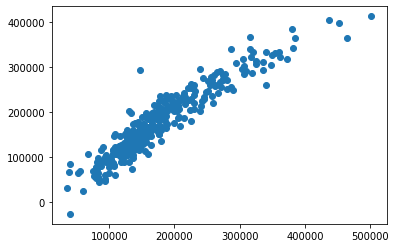

In [23]:
#check out the odd results
plt.scatter(y_test, y_pred)

The regular model is predicting a negative price throwing the whole model off. We'll try a veriety of other models.

In [24]:
y_dif = np.abs(y_test-y_pred )
y_dif.sort_values(ascending=False)[0:10]

1324    146255.080013
1243    101628.947146
178      89829.540525
377      80922.400530
714      72614.269742
533      64965.302057
93       62939.863174
970      60261.812247
297      56110.874600
980      55965.109863
Name: SalePrice, dtype: float64

In [25]:
#import models we'd like to try

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import warnings
#warnings.filterwarnings("ignore", category=[ConvergenceWarning, RuntimeWarning])
warnings.filterwarnings("ignore")

from sklearn.exceptions import ConvergenceWarning

In [26]:
#define a function to use random search to find best paramiters

from sklearn.model_selection import RandomizedSearchCV

def find_best_param(model, param_grid):
        model_cv = RandomizedSearchCV(model, param_grid, cv=5, random_state=648)
        model_cv.fit(X_train, y_train)
        return model_cv.best_estimator_



In [27]:



#define empty dicts for what we might want to access later

model_scores ={}
y_preds = {}
params_used ={}

# define funtion that calls our find_best_params function to initiate new model 
# and save our model_scores, y_preds, and params_used for each model that we try

#@ignore_warnings(category=[ConvergenceWarning, RuntimeWarning])
def scoring(model_name, model, param_grid, model_type):
    
    
    
    new_model = find_best_param(model, param_grid)
    new_model.fit(X_train, y_train)

    y_pred = new_model.predict(X_test)
    
   
    params_used[model_name] = new_model
    y_preds[model_name] = y_pred
    
    model_scores[model_name] = {'model type': model_type,
                                'cv_score': np.round(np.mean(cross_val_score(new_model, X_train, y_train, cv=5)), 2),
                                'MAE': np.round(mean_absolute_error(y_test, y_pred), 2),
                                'MSE': np.round(mean_squared_error(y_test, y_pred), 2),
                                'RMSE': np.round(mean_squared_error(y_test, y_pred, squared=False), 2),
                                'R2 score': np.round(r2_score(y_test, y_pred), 2)
                               }
    model_scores, y_preds, params_used

In [28]:
#add model 1 to model scores

model_scores['model1'] = {'model type': 'LinearRegression',
                                'cv_score': 'NA',
                                'MAE': np.round(mean_absolute_error(y_test, y_pred), 2),
                                'MSE': np.round(mean_squared_error(y_test, y_pred), 2),
                                'RMSE': np.round(mean_squared_error(y_test, y_pred, squared=False), 2),
                                'R2 score': np.round(r2_score(y_test, y_pred), 2)
                               }
                              

In [29]:
#test the find_best_params function

find_best_param(Ridge(), {'alpha': np.arange(0.001, 300)})

Ridge(alpha=100.00099999999999, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [30]:
#define params and run Ridge model

alpha_params = {'alpha': np.arange(0.001, 200)}

scoring('model2', Ridge(random_state=648), alpha_params, 'Ridge')

In [31]:
# useing same params run Lasso

scoring('model3', Lasso(random_state=648), alpha_params, 'Lasso');

In [32]:
# useing same params run ElasticNet

scoring('model4', ElasticNet(random_state=648), alpha_params, 'ElasticNet')

In [33]:
RFR_params = {'n_estimators': [300, 500, 800, 1000],
              'max_features': ['auto', 'log2'],
              'max_depth': [10, 20, 30, 40, 50, None],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 2, 5, 10, 15]
             }

scoring('model5', RandomForestRegressor(random_state=648), RFR_params, 'RandomForestRegressor')

In [34]:
# define params and run DecisionTree

DTR_params = {'max_depth': np.arange(1, 40),
              'min_samples_split': range(10, 60)}


scoring('model6', DecisionTreeRegressor(random_state=648), DTR_params, 'DecisionTreeRegressor')

In [35]:
# define params and run GradientBoost

GBR_params = {'learning_rate': [0.001, 0.01, 0.1, 0.5, 1 ],
              'n_estimators': [ 250, 500, 750, 1000],
              'max_features': ['auto', 'log2'],
              'max_depth': [ 5, 10, 25, 50],
              'min_samples_split': [ 10, 15, 20, 25, 30],
              'min_samples_leaf': [ 2, 5, 10, 15, 20, 25]
             }


scoring('model7', GradientBoostingRegressor(random_state=648), GBR_params, 'GradientBoostingRegressor')

In [36]:
# define params and run SVR

SVR_params = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              }

scoring('model8', SVR(), SVR_params, 'SVR')

In [37]:
# time to check out some scores

scores = pd.DataFrame(model_scores).T
scores


,model type,cv_score,MAE,MSE,RMSE,R2 score
model1,LinearRegression,NA,19755.2,6.6996e+08,25883.6,0.88
model2,Ridge,0.84,19877.8,6.80661e+08,26089.5,0.88
model3,Lasso,0.83,19685,6.65856e+08,25804.2,0.88
model4,ElasticNet,0.57,34745.7,2.25335e+09,47469.5,0.59
model5,RandomForestRegressor,0.86,15464.3,5.24048e+08,22892.1,0.9
model6,DecisionTreeRegressor,0.77,20760.6,8.88974e+08,29815.7,0.84
model7,GradientBoostingRegressor,0.87,13804.9,4.36792e+08,20899.6,0.92
model8,SVR,-0,52181.4,5.29723e+09,72782.1,0.03


Model 7 GradientBoost is slightly better then Lasso and Random Forest. Lets see if we can explore what is going on

In [38]:
#what values paramiters did we end up with?

#params_used

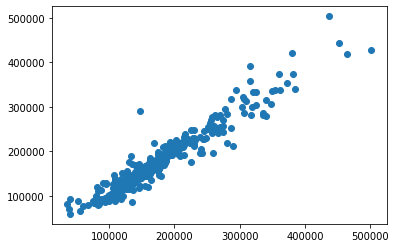

In [39]:
# a quick visual
plt.scatter(y_test, y_preds['model7'])

In [40]:
#check highest residuals
y_dif = np.abs(y_test-y_preds['model7'] )
y_dif.sort_values(ascending=False)[:10]

1324    144318.135930
1359     77671.373791
503      77237.026048
178      75032.269694
349      66586.536594
114      63394.704728
451      60479.352062
377      60014.525325
93       54812.287905
692      53695.055427
Name: SalePrice, dtype: float64

In [41]:
y_dif.describe()

count       362.000000
mean      13804.873914
std       15713.037882
min          60.381853
25%        3651.508662
50%        8783.368798
75%       18368.644637
max      144318.135930
Name: SalePrice, dtype: float64

Clearly some high redisuals for the higher priced houses. The GradientBoost is not predicting the extreams of the test set. The STD is off by about 15700 and our mean is off by almost 1400. Lets see the model on the train scores.

In [42]:
model7_train = params_used['model7']

model7_train.fit(X_train, y_train)
y_pred_train = model7_train.predict(X_train)

print('cv_score:', np.mean(cross_val_score(model7_train, X_train, y_train, cv=5)),
      'MAE:', mean_absolute_error(y_train, y_pred_train),
      'MSE:', mean_squared_error(y_train, y_pred_train),
      'RMSE:', mean_squared_error(y_train, y_pred_train, squared=False),
      'R2 score:', r2_score(y_train, y_pred_train))

cv_score: 0.8720879623098876 MAE: 6569.51017670264 MSE: 155723614.733927 RMSE: 12478.926826210938 R2 score: 0.975235783671938


The Gradient booster model is a slightly over fit on the train set. 
Lets see if we can fine tune the paramiters further and also try more gradient boosting options.

In [43]:
! pip install catboost

     |████████████████████████████████| 69.2MB 41kB/s 


In [44]:
from sklearn.model_selection import GridSearchCV
import xgboost as XGB
from catboost import CatBoostRegressor
import lightgbm as LGB

In [45]:
params_used['model7']

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=10, max_features='log2',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=10,
                          min_samples_split=30, min_weight_fraction_leaf=0.0,
                          n_estimators=750, n_iter_no_change=None,
                          presort='deprecated', random_state=648, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [46]:
#gridsearch area picked by randomsearch
param_grid = {'learning_rate': [0.008, 0.01, 0.03],
              'max_depth': [8, 10, 12],
              'max_features': ['log2'],
              'min_samples_leaf': [8, 10, 12],
              'min_samples_split':[28,  30,  32],
              'n_estimators': [650,  750,  850]}

model7_gs = GradientBoostingRegressor(random_state=648)
model7_gscv = GridSearchCV(model7_gs, param_grid, cv=5)
model7_gscv.fit(X_train, y_train)

model7_gscv.best_estimator_



GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls',
                          max_depth=12, max_features='log2',
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=12,
                          min_samples_split=30, min_weight_fraction_leaf=0.0,
                          n_estimators=650, n_iter_no_change=None,
                          presort='deprecated', random_state=648, subsample=1.0,
                          tol=0.0001, validation_fraction=0.1, verbose=0,
                          warm_start=False)

In [47]:
model9 = model7_gscv.best_estimator_
model9.fit(X_train, y_train)

y_pred = model9.predict(X_test)

y_preds['model9'] = y_pred
    
model_scores['model9'] = {'model type': 'GradientBoostingRegressor',
                        'cv_score': np.mean(cross_val_score(model9, X_train, y_train, cv=5)),
                        'MAE': mean_absolute_error(y_test, y_pred),
                        'MSE': mean_squared_error(y_test, y_pred),
                        'RMSE': mean_squared_error(y_test, y_pred, squared=False),
                        'R2 score': r2_score(y_test, y_pred)
                        }
model_scores['model9']

{'MAE': 13797.687619358874,
 'MSE': 431391247.4258103,
 'R2 score': 0.9213323283502737,
 'RMSE': 20769.960217241878,
 'cv_score': 0.8759208036238914,
 'model type': 'GradientBoostingRegressor'}

In [48]:
# define params and test xgboost


from scipy.stats import uniform, randint
XB_params = {
    "colsample_bytree": uniform(0.3, 0.7),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "subsample": uniform(0.4, 0.6),
    
}

scoring('model10', XGB.XGBRegressor( random_state=648), XB_params, "XGBRegressor")


[21:17:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:17:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [49]:
# try LGBM


LBG_params = {
    'num_leaves': [ 29, 30, 31, 32, 33],
    'min_child_samples': [16, 18, 20, 22, 24],
    'min_split_gain': [0.0, 0.001, 0.01],
    'num_iterations': [50, 75, 100],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]
}


scoring('model11', LGB.LGBMRegressor(random_state=648), LBG_params, 'LGBMRegressor')

In [50]:
 # try CatBoostRegressor
cat_params = {'iterations': [10, 25, 50],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'depth':[ 10, 20, 30]}
    
scoring('model12', CatBoostRegressor(random_state=648), cat_params, 'CatBoostRegressor')

0:	learn: 61559.2671700	total: 180ms	remaining: 4.31s
1:	learn: 45476.5362743	total: 224ms	remaining: 2.57s
2:	learn: 35427.3241706	total: 268ms	remaining: 1.96s
3:	learn: 29456.3674253	total: 312ms	remaining: 1.64s
4:	learn: 25843.6341876	total: 356ms	remaining: 1.43s
5:	learn: 23380.8034530	total: 403ms	remaining: 1.27s
6:	learn: 21598.4193056	total: 449ms	remaining: 1.15s
7:	learn: 19715.9575221	total: 492ms	remaining: 1.05s
8:	learn: 18648.4914154	total: 536ms	remaining: 953ms
9:	learn: 17411.9099231	total: 580ms	remaining: 869ms
10:	learn: 15939.1509314	total: 638ms	remaining: 812ms
11:	learn: 15470.1418472	total: 682ms	remaining: 738ms
12:	learn: 14934.5272425	total: 725ms	remaining: 669ms
13:	learn: 14492.9670352	total: 769ms	remaining: 604ms
14:	learn: 13637.0238068	total: 814ms	remaining: 543ms
15:	learn: 13279.4446342	total: 866ms	remaining: 487ms
16:	learn: 12385.8695211	total: 910ms	remaining: 428ms
17:	learn: 12240.4592595	total: 953ms	remaining: 371ms
18:	learn: 11638.188

In [51]:
scores = pd.DataFrame(model_scores).T
scores

,model type,cv_score,MAE,MSE,RMSE,R2 score
model1,LinearRegression,NA,19755.2,6.6996e+08,25883.6,0.88
model2,Ridge,0.84,19877.8,6.80661e+08,26089.5,0.88
model3,Lasso,0.83,19685,6.65856e+08,25804.2,0.88
model4,ElasticNet,0.57,34745.7,2.25335e+09,47469.5,0.59
model5,RandomForestRegressor,0.86,15464.3,5.24048e+08,22892.1,0.9
model6,DecisionTreeRegressor,0.77,20760.6,8.88974e+08,29815.7,0.84
model7,GradientBoostingRegressor,0.87,13804.9,4.36792e+08,20899.6,0.92
model8,SVR,-0,52181.4,5.29723e+09,72782.1,0.03
model9,GradientBoostingRegressor,0.875921,13797.7,4.31391e+08,20770,0.921332
model10,XGBRegressor,0.86,14481.4,4.57588e+08,21391.3,0.92


model9 our refined GradientBoostingRegressor is the best RMSE score

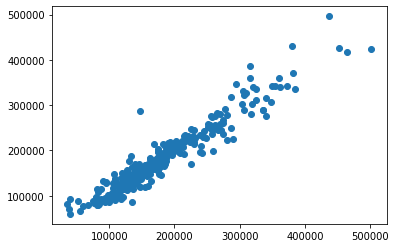

In [52]:
plt.scatter(y_test, y_preds['model9'])

<function matplotlib.pyplot.show>

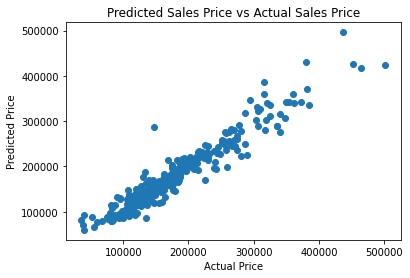

In [53]:
ax = plt.scatter(y_test, y_preds['model9'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted Sales Price vs Actual Sales Price')
plt.show

In [54]:
y_dif = np.abs(y_test-y_preds['model9'] )
y_dif.sort_values(ascending=False)[:10]

1324    139306.038292
178      77480.454282
1359     71375.640075
503      64467.307991
377      64038.023678
114      61760.761077
349      59291.072716
451      58037.405265
607      55936.155945
93       53682.879805
Name: SalePrice, dtype: float64

In [55]:
y_dif.describe()

count       362.000000
mean      13797.687619
std       15546.147289
min          33.636361
25%        3587.018766
50%        8791.577671
75%       17649.612473
max      139306.038292
Name: SalePrice, dtype: float64

While the predictions are still off on every house sale, the meadian residual is less then $9,000$. Time predict and submit the competition dataset.

In [56]:
# Prepare data to submit to competition

df_test = scaler.transform(df_test[houses_num_col])


model9_pred = model9.predict(df_test)

pred = pd.DataFrame(model9_pred)
submission3 = pd.concat([Id, pred], axis=1)
submission3.columns = ['Id','SalePrice']

submission3

,Id,SalePrice
0,1461,125948.816520
1,1462,160041.686778
2,1463,185665.174518
3,1464,191846.444490
4,1465,183203.218281
...,...,...
1454,2915,86435.536837
1455,2916,89768.640947
1456,2917,163609.679212
1457,2918,119294.488982


In [57]:
submission3.to_csv('submission3.csv', index =False)
# kaggle competition recieves a score (logarithmic RMSE) of 0.14051
# number 6352 on the leaderboard at time of submition

In [58]:
model9_train = model9

model9_train.fit(X_train, y_train)
y_pred_train = model9_train.predict(X_train)

print('cv_score:', np.mean(cross_val_score(model7_train, X_train, y_train, cv=5)),
      'MAE:', mean_absolute_error(y_train, y_pred_train),
      'MSE:', mean_squared_error(y_train, y_pred_train),
      'RMSE:', mean_squared_error(y_train, y_pred_train, squared=False),
      'R2 score:', r2_score(y_train, y_pred_train))

cv_score: 0.8720879623098876 MAE: 6824.615816377072 MSE: 192149455.40293217 RMSE: 13861.79841878146 R2 score: 0.9694431015549704


In [59]:
y_train_dif = np.abs(y_train-y_pred_train)
y_train_dif.describe()

count      1085.000000
mean       6824.615816
std       12070.972114
min           3.326972
25%        1983.742014
50%        4281.898613
75%        7997.174236
max      254931.387738
Name: SalePrice, dtype: float64

The gradient boost model is slightly overfitting but simply is not perdicting high enough prices even on the train set. 
This Bias is hard to correct with all of the outliers.